In [6]:
import numpyro

numpyro.enable_x64()
numpyro.set_platform('cpu') # set it to cpu and increase the number of devices if required

# MOCK LOSER Q DYNAMICS

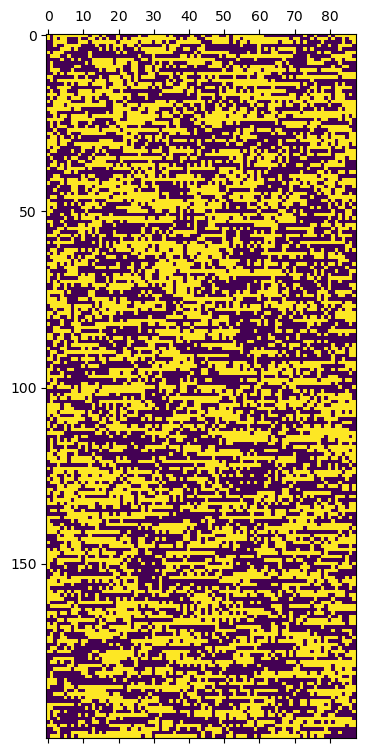

In [17]:
import numpy as np 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey
from helper import StateTools

markov_util_ref = StateTools(4)

probs = jnp.empty((2**4))
probs_keys = {0. : 0.25, 0.25:1/3, 0.5:0.5, 0.75:2/3, 1.:0.75}

for i, state in enumerate(markov_util_ref.get_states()):
    probs = probs.at[i].set(probs_keys[sum(state)/4])
    
mock_history_encoded = markov_util_ref.build_process(85, probs=probs).sample(200, seed=PRNGKey(42))
mock_history = np.apply_along_axis(markov_util_ref.categorical_serie_to_binary, 1, mock_history_encoded)
plt.matshow(mock_history);

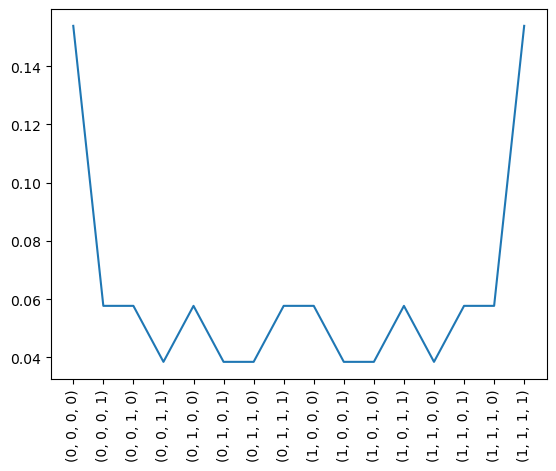

In [18]:
stat_distribution = markov_util_ref.stationary_distribution(probs)
states = markov_util_ref.get_states()
plt.plot([str(x) for x in states], stat_distribution)
plt.xticks(rotation=90);

In [ ]:
import arviz as az 
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey

dict_of_id = {}

for i in [4]:#range(10):
    
    markov_util = StateTools(i)

    def model():
        
        if i != 0: 
            proba = numpyro.sample('proba', dist.Uniform(low=jnp.zeros(2**markov_util.n), high=jnp.ones(2**markov_util.n)))
        else:
            proba = numpyro.sample('proba', dist.Uniform(low=0, high=1))*jnp.ones(2**markov_util.n)
            
        transition_matrix = markov_util.build_transition_matrix(proba)
        
        def transition_fn(_, x):
            return tfd.Categorical(probs=transition_matrix[x])
        
        encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, mock_history)
        
        likelihood_dist = tfd.MarkovChain(
                initial_state_prior=tfd.Categorical(probs=markov_util.uniform_prior),
                transition_fn=transition_fn,
                num_steps=encoded_history.shape[1]
        )
        
        numpyro.sample('likelihood', likelihood_dist, obs=encoded_history)

    kernel = NUTS(model)
    num_samples = 2000
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4)
    mcmc.run(
        PRNGKey(0)
    )
    mcmc.print_summary()
    
    dict_of_id[str(i)] = az.from_numpyro(mcmc)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [52]:
az.compare(dict_of_id)

/Users/sdupourque/opt/anaconda3/envs/truskill2/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/sdupourque/opt/anaconda3/envs/truskill2/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
4,0,-25849.878047,16.468009,0.000000,0.985111,90.903447,0.000000,False,log
5,1,-25881.087586,32.408370,31.209539,0.000000,90.275287,6.587192,False,log
3,2,-26279.314273,9.017546,429.436226,0.000000,88.706966,31.122280,False,log
2,3,-26817.840274,5.712086,967.962227,0.010527,80.916948,45.306857,False,log
1,4,-27464.129328,4.143469,1614.251281,0.000000,57.727650,55.848745,False,log
0,5,-28545.653060,4.391194,2695.775013,0.004362,11.274274,90.249363,False,log


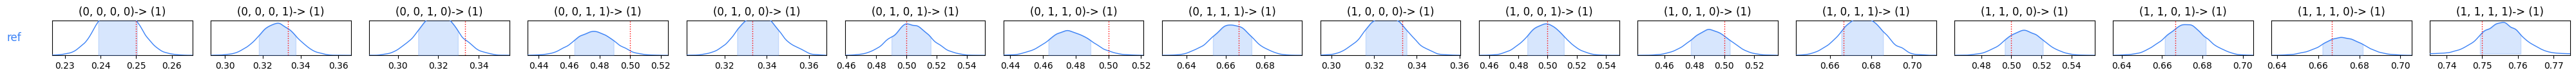

In [90]:
import pandas as pd 
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['4']
samples = np.asarray(az.extract(best_id).proba)

dict_of_samples = {str(state) + '-> (1)':samples[i] for i, state in enumerate(markov_util_ref.get_states())}

cc = ChainConsumer()
cc.add_chain(Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name='ref'))
cc.add_truth(Truth(location={str(state) + '-> (1)':probs_keys[sum(state)/4] for i, state in enumerate(markov_util_ref.get_states())}, line_style=":", color="red"))
"""
cc.plotter.plot_summary()
plt.tight_layout()
plt.savefig('test_summaries.png', bbox_inches='tight')
"""

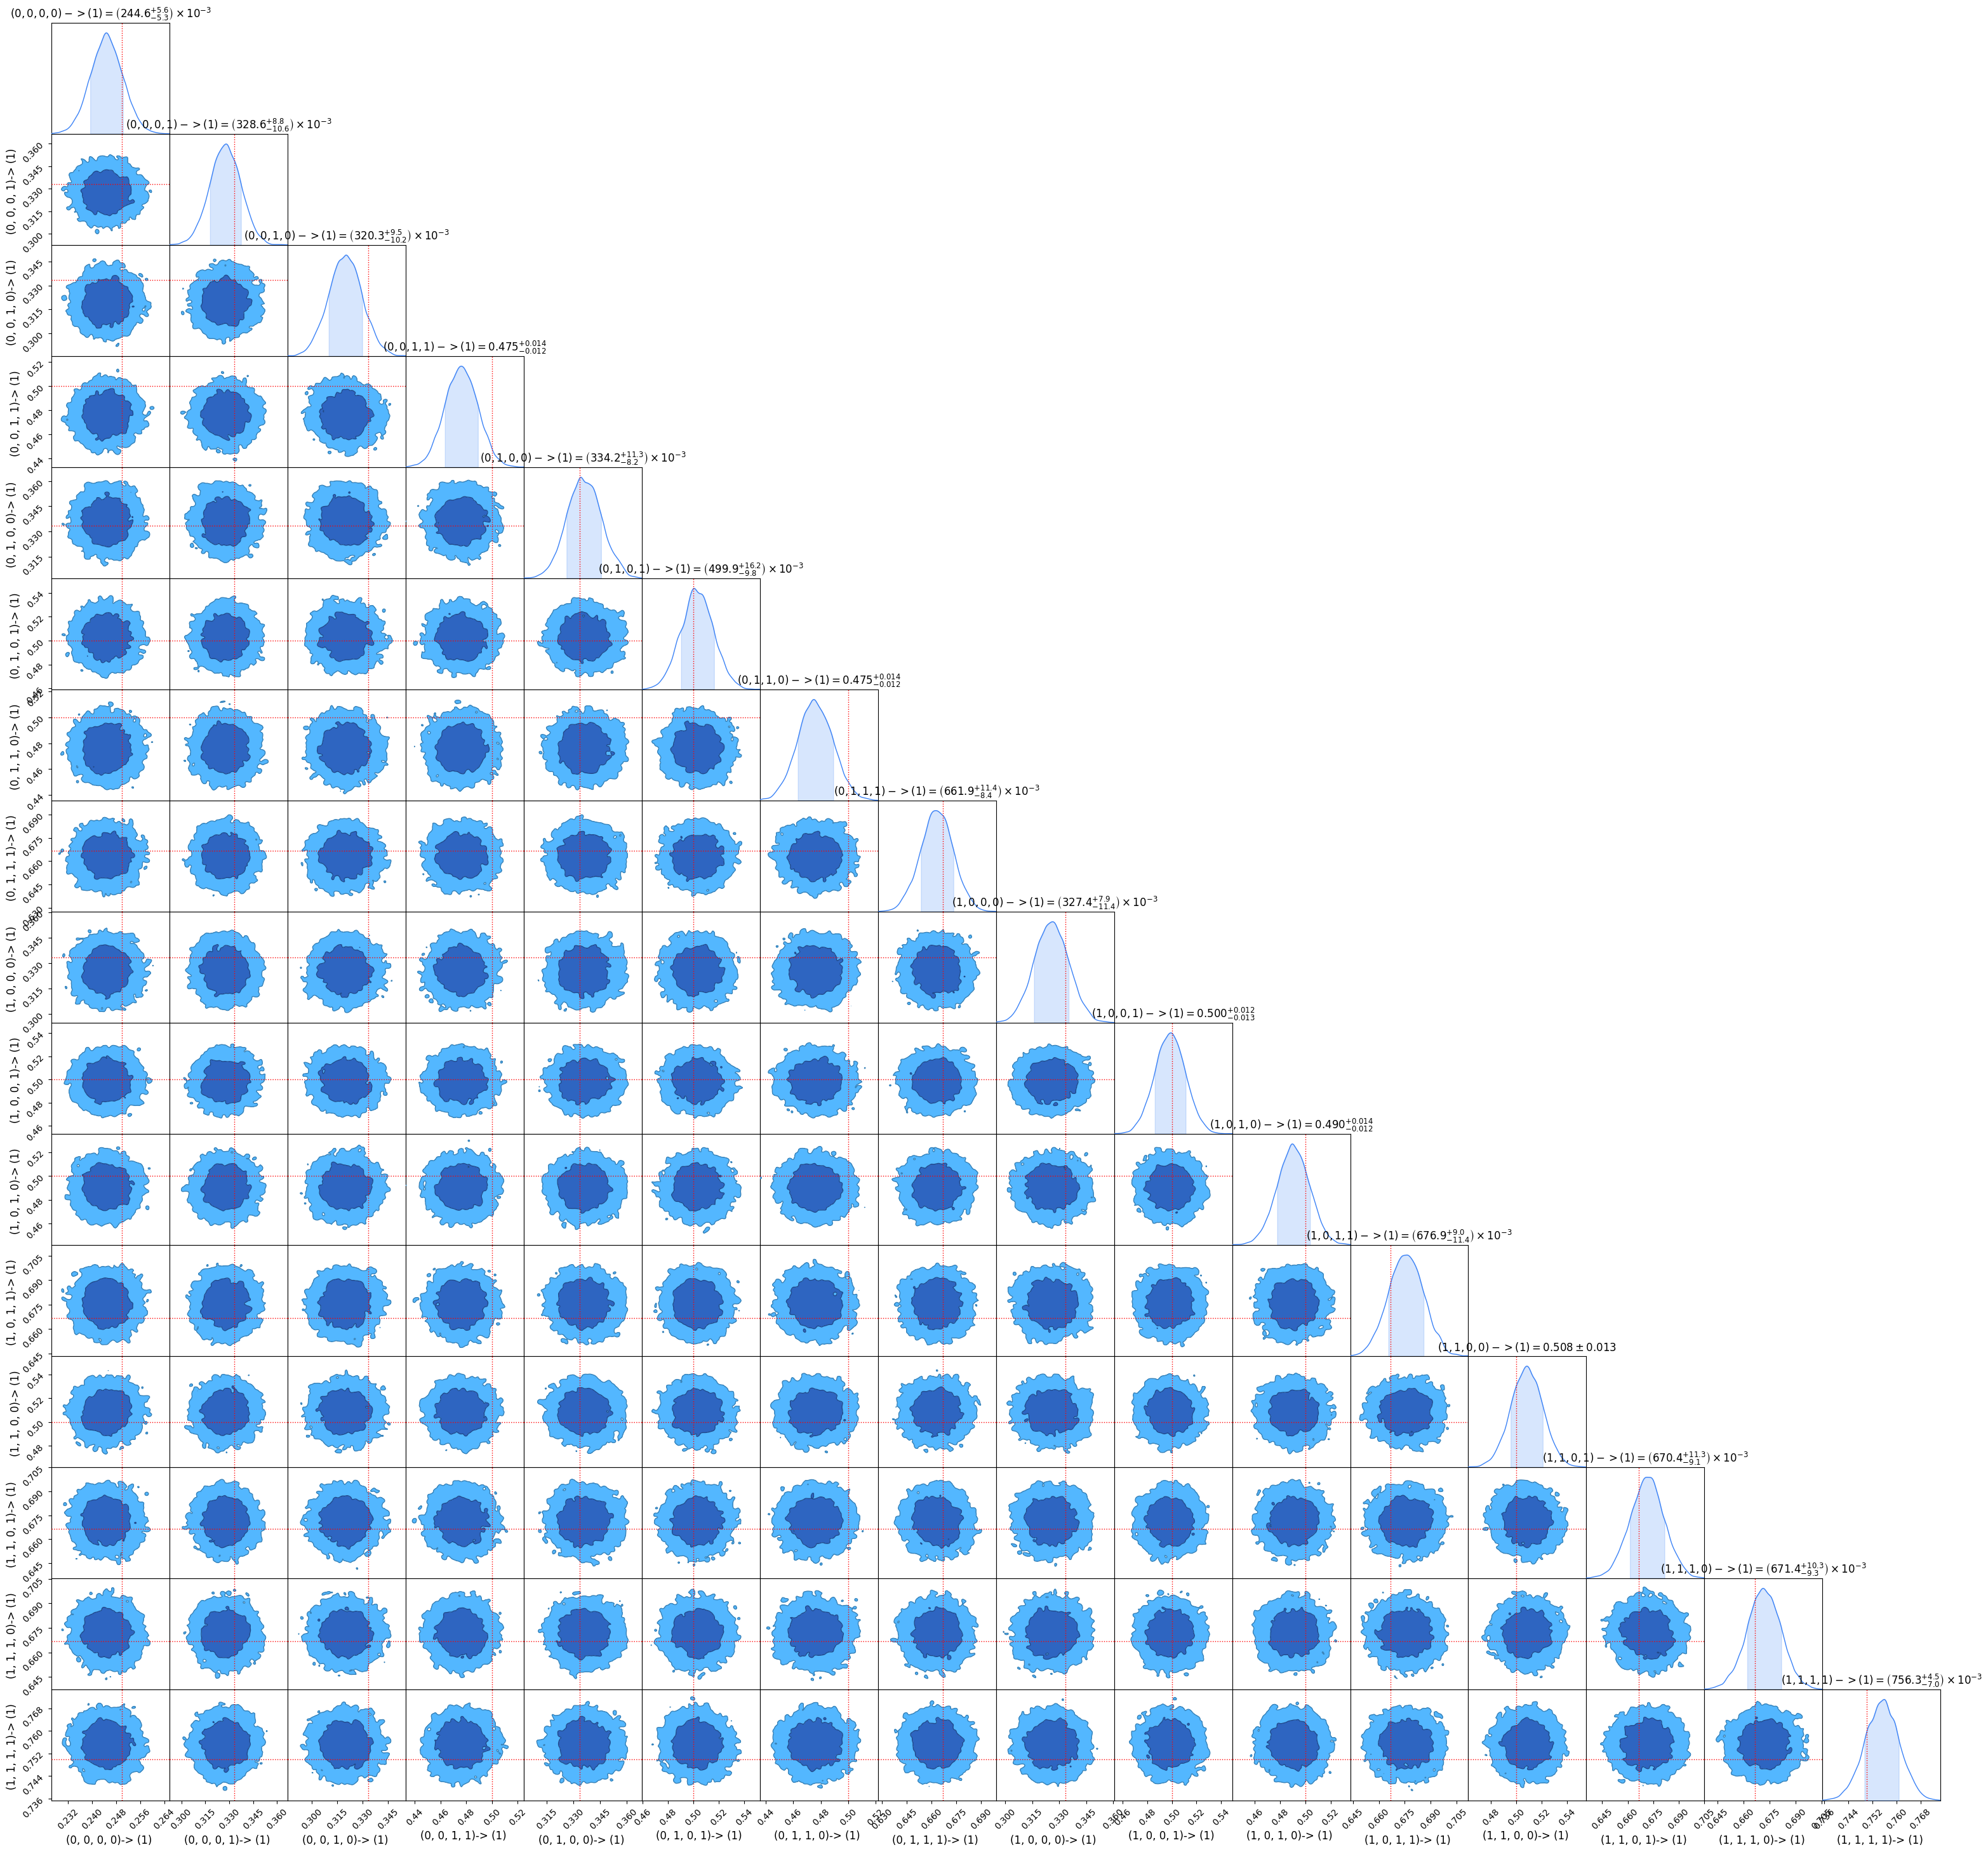

In [91]:
cc.plotter.plot()
plt.savefig('test_summaries_corner.png', bbox_inches='tight')

In [32]:
from jax.tree_util import tree_flatten, tree_map, tree_reduce

smallest_history_size = tree_reduce(min, tree_map(lambda x: x.shape[0], history))
flat_tree, _ = tree_flatten(tree_map(lambda x: x[-smallest_history_size:], history))
observed_history = jnp.asarray(flat_tree)

In [33]:
markov_util = StateTools(2)
encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)

In [34]:
import arviz as az 
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey

dict_of_id = {}

for i in range(3):
    
    markov_util = StateTools(i)

    def model():
        
        if i != 0: 
            proba = numpyro.sample('proba', dist.Uniform(low=jnp.zeros(2**markov_util.n), high=jnp.ones(2**markov_util.n)))
        else:
            proba = numpyro.sample('proba', dist.Uniform(low=0, high=1))*jnp.ones(2**markov_util.n)
            
        transition_matrix = markov_util.build_transition_matrix(proba)
        
        def transition_fn(_, x):
            return tfd.Categorical(probs=transition_matrix[x])
        
        encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)
        
        likelihood_dist = tfd.MarkovChain(
                initial_state_prior=tfd.Categorical(probs=markov_util.uniform_prior),
                transition_fn=transition_fn,
                num_steps=encoded_history.shape[1]
        )
        
        numpyro.sample('likelihood', likelihood_dist, obs=encoded_history)

    kernel = NUTS(model)
    num_samples = 2000
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4)
    mcmc.run(
        PRNGKey(0)
    )
    mcmc.print_summary()
    
    dict_of_id[str(i)] = az.from_numpyro(mcmc)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     proba      0.50      0.00      0.50      0.50      0.50   3169.64      1.00

Number of divergences: 0


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  proba[0]      0.50      0.00      0.50      0.50      0.50   7881.35      1.00
  proba[1]      0.51      0.00      0.51      0.50      0.51   6600.76      1.00

Number of divergences: 0


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  proba[0]      0.50      0.00      0.50      0.49      0.50  10200.67      1.00
  proba[1]      0.50      0.00      0.50      0.50      0.51  10996.58      1.00
  proba[2]      0.50      0.00      0.50      0.50      0.50   8556.50      1.00
  proba[3]      0.51      0.00      0.51      0.50      0.51   9505.11      1.00

Number of divergences: 0


In [35]:
az.compare(dict_of_id)

/Users/sdupourque/opt/anaconda3/envs/truskill2/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/sdupourque/opt/anaconda3/envs/truskill2/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
1,0,-184787.120968,1.837284,0.000000,0.593601,3.910528,0.000000,False,log
2,1,-184787.544515,3.811654,0.423547,0.319238,4.292115,1.481163,False,log
0,2,-184792.494304,0.875924,5.373336,0.087161,1.586679,3.574372,False,log


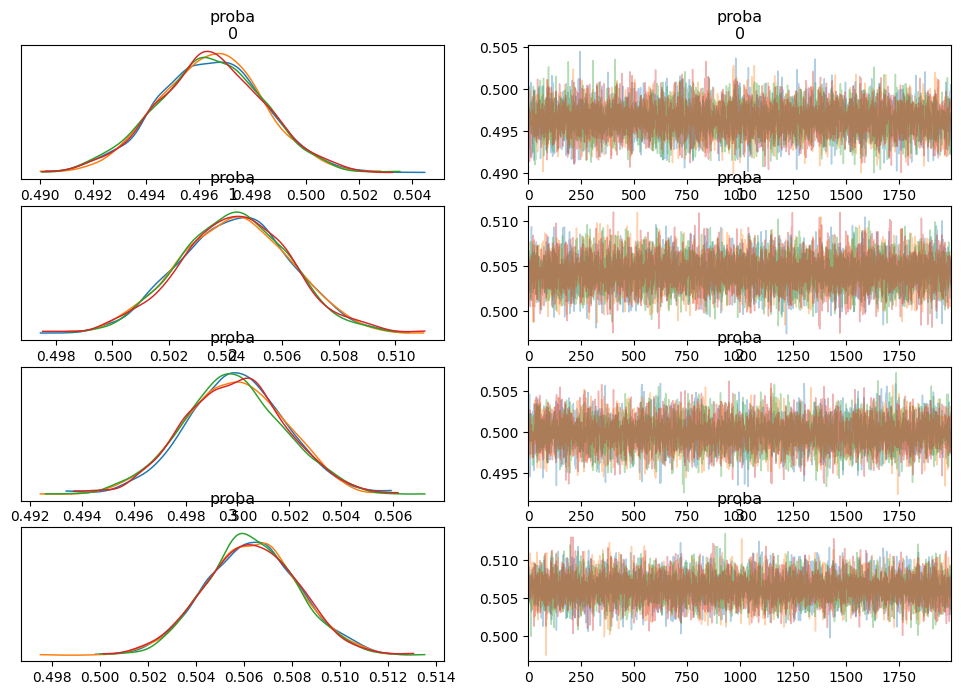

In [24]:
az.plot_trace(dict_of_id[str(2)], compact=False);